In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import cartopy.io.img_tiles as cimgt

from datetime import datetime

# obspy
import obspy
from obspy.clients.fdsn import mass_downloader
from obspy.clients.fdsn import Client
from obspy import read, Stream
from obspy.geodetics import gps2dist_azimuth,locations2degrees
from obspy.clients.fdsn.mass_downloader.domain import GlobalDomain


# os and system calls
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from tqdm import tqdm
import logging

# custom modules
sys.path.append('/home/gcl/BR/sbrisson/bsl_internship_toolbox')

from data_acquisition.distance_azimuth_domain import DistanceAzimuthDomain, DistanceNorthAzimuthDomain
from data_acquisition.mdl_plotting import plot_event, plot_stations

from data_acquisition.globalcmt_request import getEventById, GlobalCMT_search


# constants

Rt = 6371000.

***Getting Event Information***

Kai used events : 
| ID | Origin Time | Longitude | Latitude | Depth | Magnitude | Region | Distance |
|-------|---------------|---------------|-----------|-----------|-----------|-------------------|-----------|
| 1 | 2014/08/18 | 47.53 | 32.59 | 12.0km | Mw 6.2 | Iran-Iraq Border | 85-110° |
| 2 | 2007/11/29 | -61.41 | 15.06 | 147.9km | Mw 7.4 | Windward Island | 120-140° |
| 3 | 2015/10/26 | 70.42 | 36.55 | 209.4km | Mw 7.5 | Hindu Kush | 89-110° |
| 5 | 2016/08/24 | 94.58 | 20.79 | 101.1km | Mw 6.8 | Myanmar | 100-130° |

In [4]:
#---------------
# configuration

# fiji events
# date = "2022/02/16"
# date = "2012/04/23"

# indonesia events
date = "2019/09/19" # en, fait non, distances trop faibles
date = "2022/01/04"

# indo events with good RPs
date = "2013/09/01"
date = "2016/08/23"
# date = "2018/12/01"
# date = "2020/01/18"

origin_time_search = obspy.UTCDateTime(date)
Mw_min = 5.9
client_cmt = Client("USGS")

os.chdir("/home/gcl/BR/sbrisson/getting_observation_data_ULVZs")

#---------------

In [5]:
n_min = 12*60
events_usgs = client_cmt.get_events(
    starttime=origin_time_search-60*n_min, 
    endtime=origin_time_search+60*n_min, 
    minmagnitude=Mw_min,
    includeallorigins=True
    )

print(">> USGS catalogue")
print(events_usgs)

>> USGS catalogue
1 Event(s) in Catalog:
2013-09-01T11:52:29.930000Z |  -7.440, +128.221 | 6.5 mww | manual


In [14]:
# with global CMT catalogue

gcmt = GlobalCMT_search(
        date = datetime.strptime(date, '%Y/%m/%d'),
        Mw_min = 5.9,
    )     
events_gcmt = gcmt.get_cmt_solution()
print("Global CMT catalogue")
print(events_gcmt)

Global CMT catalogue
3 Event(s) in Catalog:
2022-01-04T03:18:41.610000Z | +35.190,  -35.440 | 5.98 mw
2022-01-04T18:31:58.310000Z | -20.540, +169.680 | 5.87 mw
2022-01-04T20:55:48.540000Z |  -4.790, +125.010 | 6.05 mw


In [6]:
# pick the event you want
event = events_usgs[0]
# event = events_gcmt[2]

event_id = f"{event.magnitudes[0].mag:1.1f}_{event.origins[0].time.date.strftime('%d-%b-%Y')}"
print(f"Event ID : {event_id}")

Event ID : 6.5_01-Sep-2013


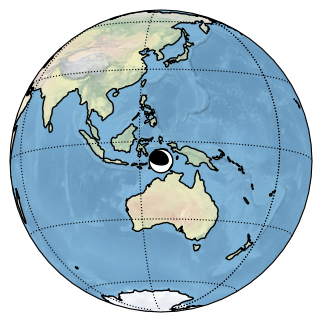

In [7]:
if event.preferred_focal_mechanism().moment_tensor:
    plot_event(event)
else:
    print("No moment tensor")

In [8]:
# building the data repository
if not(os.path.exists(event_id)):
    print(f">> Creating event directory {event_id}")
    os.mkdir(event_id)
os.chdir(event_id)

>> Creating event directory 6.5_01-Sep-2013


In [9]:
# getting and writting event info
# - all info in CMTSOLUTION format
# - the info needed for forward simulations in a source.dat file

quakeMLfile = "event.xml"
sourceDatfile = "source.dat"
print(f">> Writting event information in {sourceDatfile} and {quakeMLfile}")

tensor = event.preferred_focal_mechanism().moment_tensor.tensor
ev_lat = event.preferred_origin().latitude
ev_lon = event.preferred_origin().longitude
ev_dep = event.preferred_origin().depth
origin_time = event.preferred_origin().time

ev_colat = ev_lat + 90.
ev_radius = Rt - ev_dep

with open(sourceDatfile, 'w') as out:

    out.write(
    f"""# Position (colatitude(°), longitude(°), radius(m))
{ev_colat:8.4f}
{ev_lon:8.4f}
{ev_radius}
# Centroid Moment Tensor (N.m) (m_rr,m_tt,m_pp,m_rt,m_rp,m_tp)
{tensor.m_rr}
{tensor.m_tt}
{tensor.m_pp}
{tensor.m_rt}
{tensor.m_rp}
{tensor.m_tp}"""
    )

event.write(quakeMLfile, format="CMTSOLUTION")

>> Writting event information in source.dat and event.xml


***Get available stations***

In [10]:
class MyStation:
    def __init__(self, code, nw, lat, lon):
        self.code= code
        self.nw  = nw
        self.lat = lat
        self.lon = lon
        
class MyInventory:
    
    def __init__(self):
        self.stations = pd.DataFrame({'code':[],'nw':[],'lat':[],'lon':[]})
        
    def append(self, station):
        self.stations.loc[len(self.stations.index)] = [station.code, station.nw, station.lat, station.lon]
        
    def plot(self):
                
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        # ax.add_feature(cfeature.LAND)
        # ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.scatter(self.stations["lon"],self.stations["lat"], transform = ccrs.PlateCarree(), marker="v", ec="k", s = 100, label=self.stations["nw"])
        
        extent = ax.get_extent()
        ax.stock_img()
        ax.set_extent(extent, crs=ccrs.PlateCarree())


        # add box with orthographic projection
        meanLon = (extent[0]+extent[1])/2
        meanLat = (extent[2]+extent[3])/2
        sub_ax = fig.add_axes([0.65, 0.65, 0.2, 0.2],projection=ccrs.Orthographic(central_latitude=meanLat, central_longitude=meanLon))
        sub_ax.add_feature(cfeature.LAND)
        sub_ax.add_feature(cfeature.OCEAN)

        print(extent)
        extent_box = sgeom.box(extent[0], extent[2], extent[1], extent[3])
        sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=2)
        
    def __repr__(self):
        return self.stations.__repr__()
    def len(self):
        return self.stations.shape[0]
    def nb_networks(self):
        return self.stations["nw"].drop_duplicates().shape[0]
    
    def write(self):
        """Write to receivers.dat file"""
        f = open('receivers.dat', 'w')
        f.write(f"Nombre de stations:\n{len(self.stations.index)}\nnw stn lat lon:\n")
        for index, row in self.stations.iterrows():
            f.write(f"{row['nw']:<2} {row['code']:<4} {row['lat']:2.4f} {row['lon']:2.4f}\n")
        f.close()

    def read_fromDat(self):
        df = pd.read_csv("receivers.dat", header = 2, sep = "\s+")
        df.rename(columns = {'stn':'code', 'lon:':'lon'}, inplace = True) 
        self.stations = df       

In [11]:
# 1. get available stations then select

client_wf = Client("IRIS")

# time bounds
tmin_after_event = 500.
tmax_after_event = 2500.

# ----------------------------------
# configuration
# I use https://ds.iris.edu/wilber3 to determine these
dmin  = 85.0
dmax  = 130.0
azmin = -40.0
azmax = 40.0

# # for fiji events to south america
# lat_pivot = -30.
# lon_pivot = -110.

# indonesia events to Africa
lat_pivot = -10.
lon_pivot = 50.
dmin  = 70.0
dmax  = 120.0

# ----------------------------------

>> Refining station catalogue over azimuth with respect to the pivot point
>> distance-azimuth bounded domain
- centered upon (-7.4°lat,128.2°lon)
- distance in [70.0,120.0]°
- azimuth in  [-40.0,40.0]°, with respect to the pivot point (-10.0°lat,50.0°lon)


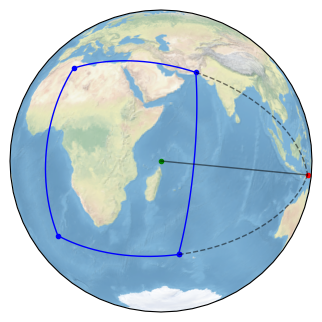

In [12]:
domain = DistanceAzimuthDomain(
        lat_center  = ev_lat,
        lon_center  = ev_lon,
        lat_pivot   = lat_pivot,
        lon_pivot   = lon_pivot,
        dmin        = dmin, 
        dmax        = dmax, 
        azmin       = azmin, 
        azmax       = azmax,
    )

print(f">> Refining station catalogue over azimuth with respect to the pivot point")
print(domain)
domain.plot()
plt.show();

In [13]:
# saving configuration

config = {
    "domain" : {
        "dmin" : dmin,
        "dmax" : dmax,
        "azmin" : azmin, 
        "azmax" : azmax,
        "lat_ulvz" : lat_pivot,
        "lon_ulvz" : lon_pivot,
    },
    "time_bounds" : {
        "origin_time" : origin_time.__repr__(),
        "tmin_after_event" : tmin_after_event,
        "tamx_after_event" : tmax_after_event,
    },
    "channel" : "BHZ,HHZ",
    "location_priorities" : ["","00", "10", "01", "02"],
    "provider" : "IRIS",
    "reject_channels_with_gaps" : True,
    "minimum_interstation_distance_in_m" : 1e2
}

In [14]:
print(">> Looking for available stations based upon :")
print(f"- time criteria : between {origin_time+tmin_after_event} and {origin_time+tmax_after_event}")
print(f"- distance criteria : between {dmin:.1f}° and {dmax:.1f}°")


networks_inventory = client_wf.get_stations(
    channel="BHZ,HHZ",
    starttime=origin_time+tmin_after_event,
    endtime=origin_time+tmax_after_event,
    latitude = ev_lat,
    longitude= ev_lon,
    minradius=dmin,
    maxradius=dmax
    )

nb_stations = sum([len(network) for network in networks_inventory])
print(f"Found {nb_stations} stations, over {len(networks_inventory)} networks.")

>> Looking for available stations based upon :
- time criteria : between 2013-09-01T12:00:49.930000Z and 2013-09-01T12:34:09.930000Z
- distance criteria : between 70.0° and 120.0°
Found 1852 stations, over 111 networks.


In [15]:
stations = MyInventory()

for nw in networks_inventory.networks:
    for st in nw._stations:
        if domain.is_in_domain(st._latitude, st._longitude):
            stations.append(MyStation(st.code, nw.code, st._latitude, st._longitude))

In [16]:
print(">> Writting stations informations in receivers.dat")
stations.write()

>> Writting stations informations in receivers.dat


In [17]:
# or get from file
stations = MyInventory()
stations.read_fromDat()

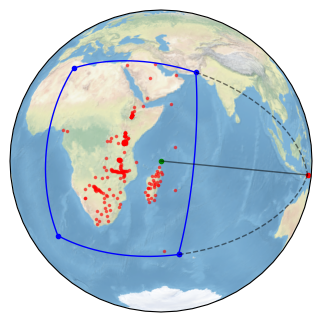

In [18]:
ax = domain.plot()
ax.scatter(stations.stations["lon"],stations.stations["lat"], transform = ccrs.PlateCarree(), marker=".", s = 10, color="r", alpha=0.5)
plt.savefig("domain_search.png", dpi=500)

(6.98419, 58.54801, -50.242709999999995, 33.614909999999995)


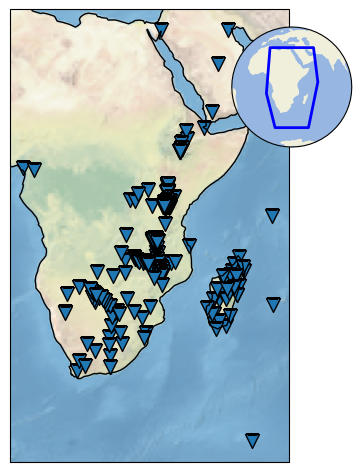

In [19]:
stations.plot()

***Getting waveform data***

In [20]:
# Location priorities:
location_priorities = ("","00", "10", "01", "02")

# Channel priorities
channel_priorities = ("BH[ZNE12]", "LH[ZNE12]")

# Mass downloader over IRIS
# mdl = mass_downloader.MassDownloader( providers= ["IRIS"], configure_logging=False)
mdl = mass_downloader.MassDownloader( providers= ["IRIS"])

# Data directories
stations_dir = "stations"
wf_dir = "waveforms"

# Global domain (stations filtered to be inside directionnal domain)
global_domain = GlobalDomain()

# log to a file and not in stdout
logger = logging.getLogger("obspy.clients.fdsn.mass_downloader")
handler = logging.FileHandler('mass_downloader.log')
logger.addHandler(handler) 

[2022-06-21 12:50:57,325] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2022-06-21 12:50:57,336] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.


In [21]:
# This loop might seem quite inefficient to you and it is. However, 
# the MassDownloader does not always download all the data requested if the
# list of stations is too large. Then, the user should re-run the MassDownloader
# a couple of times. As an alternative, we here run it for each station.

for nw_code,st_code in tqdm(zip(stations.stations["nw"],stations.stations["code"]), total=stations.len(),unit="station"):
    
    # print(f"Downloading data for station {nw_code:<2}.{st_code:<4} ({i/stations_in.len()*100:.0f}%).", end="\r")

    # set Restrictions
    restrictions = mass_downloader.Restrictions( 
                            starttime   = origin_time +tmin_after_event,
                            endtime     = origin_time +tmax_after_event,
                            location_priorities = location_priorities,
                            channel_priorities = channel_priorities,
                            reject_channels_with_gaps = True,
                            minimum_interstation_distance_in_m=1E2,
                            network = nw_code, station = st_code )

    # Start download
    mdl.download(
        global_domain, 
        restrictions, 
        mseed_storage = wf_dir, 
        stationxml_storage = stations_dir,
        print_report=False )

  0%|          | 0/229 [00:00<?, ?station/s][2022-06-21 12:50:58,008] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2022-06-21 12:50:58,009] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2022-06-21 12:50:58,225] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.21 seconds)
[2022-06-21 12:50:58,228] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 1 stations (3 channels).
[2022-06-21 12:50:58,230] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 1 stations.
[2022-06-21 12:50:58,239] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 3 time intervals/channels before downloading: NEEDS_DOWNLOADING
[2022-06-21 12:50:58,782] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully downloaded 3 channels (of 3)
[2022-06-21 12:50:58,786] - obspy.clients

***Extracting station information***

150 stations.


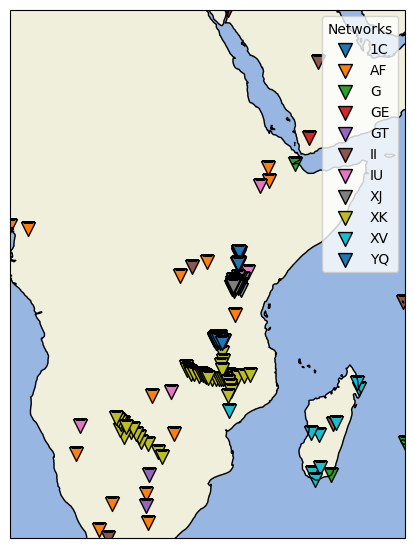

In [22]:
# loading station data
stations2 = obspy.read_inventory("stations/*")
print(f"{len(stations2)} stations.")
plot_stations(stations2);

In [23]:
# writting in a receivers.dat file
with open("receivers.dat", 'w') as out:
    header = ["Number of stations is:",len(stations2),"nw stn lat lon:"]
    out.writelines(f"{l}\n" for l in header)
    for nw in stations2:
        nw_code = nw.code
        for stn in nw:
            code = stn.code
            lat,lon = stn.latitude,stn.longitude
            out.write(f"{nw_code:<2} {code[:4]:<4} {lat:8.4f}  {lon:8.4f}\n")
        

***processing waveform data***

In [24]:
# Reading waveform data into a stream obspy object
wf_dir = "waveforms"
st = Stream()
for waveform in os.listdir(wf_dir):
    st += read(os.path.join(wf_dir, waveform))

In [26]:
stations2.get_coordinates(st[0].id)

{'latitude': 1.0368,
 'longitude': 36.30999,
 'elevation': 871.0,
 'local_depth': 0.0}

In [27]:
dist_list = []

# computing aditionnal metadata
for tr in st:
    
    st_coordinates = stations2.get_coordinates(tr.id)
    st_lat = st_coordinates["latitude"]
    st_lon = st_coordinates["longitude"]
    
    tr.stats.coordinates = st_coordinates
    
    tr.stats.evla = ev_lat
    tr.stats.evlo = ev_lon
    tr.stats.evde = ev_dep/1000
    tr.stats.event_origin_time = origin_time
            
    _,b_az,_ = gps2dist_azimuth(st_lat, st_lon, ev_lat, ev_lon)
    dist = locations2degrees(st_lat, st_lon, ev_lat, ev_lon)
    
    tr.stats.back_azimuth = b_az # for rotation
    tr.stats.distance = dist
    
    dist_list.append(dist)

In [28]:
print(f"Distances between {min(dist_list):.1f}° and {max(dist_list):.1f}°")

Distances between 71.0° and 119.2°


In [29]:
# interpolating and triming
st.interpolate(sampling_rate=5.0);

In [30]:
# rotating it
stations3 = set([tr.stats.station for tr in st])
st._trim_common_channels()

for station in stations3:                       
    try:
        st.select(station=station).rotate('NE->RT')
    except ValueError:
        print(f"Couldn't rotate:\n{st.select(station=station)}")

In [31]:
# filtering it
ifmin = 20.0
ifmax = 10.0
st.filter('bandpass', freqmin=1/ifmin, freqmax=1/ifmax);

In [32]:
# saving it into serialized stream object (pickle format)
out_file =  f"{event_id}_{ifmax:.0f}s-{ifmin:.0f}s.pickle"
print(f">> Writting {out_file}")
st.write(out_file, format='PICKLE')

>> Writting 6.5_01-Sep-2013_10s-20s.pickle
